<a href="https://colab.research.google.com/github/basanaz/hu-reinforcement-learning-gym/blob/master/1_Hogeschool_Utrecht_Reinforcement_Learning_project_Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning project - Q-Learning




## Aim
In this lab we are going to solve two simple [OpenAI Gym](https://gym.openai.com/) environments using [Q-Learning](https://en.wikipedia.org/wiki/Q-learning). Specifically, the [CartPole-v0](https://gym.openai.com/envs/CartPole-v0/) and [MountainCar-v0](https://gym.openai.com/envs/MountainCar-v0/) environments.

We will try to create a table containing the expected reward for each combination of a *state* and *action*. We will use this table to choose the (hopefully) best action given the state the system is in.

While this may not be the most advanced or complicated model there is, it is perfect for this task! Furthermore, it can be trained in a relatively short time!

## Runtime and environment
This [Jupyter Notebook](https://jupyterlab.readthedocs.io/en/latest/) was made to run on Google Colab. For this training, we recommend using the Google Colab environment.

Please read the [instructions on Google Colab](https://medium.com/swlh/the-best-place-to-get-started-with-ai-google-colab-tutorial-for-beginners-715e64bb603b) to get started quickly. It behaves similar to Jupyter Notebook, Jupyter Hub and Jupyter Lab, so if you have any experience with those, you're good to go!

Some notes on Google Colab:
- **Processes in Google Colab won't run forever**. These may be terminated at any time when the platform is crowded, and *will definitely* terminate after 12 hours. To maintain persistency, you can attach the session to **Google Drive** and have your models persist themselves to the Google Drive periodically.
- You can enable GPU or TPU support! You can find this option under *Runtime* -> *Change runtime type*.
- After installing dependencies, you need to restart the runtime in order to actually use them.

If you want to run the code on your own platform or system, you need to keep a few things in mind:
- The dependencies you need to install may differ from the ones we installed here. The installed dependencies are suitable for Google Colab, Ubuntu, and Debian.
- Since Google Colab isn't attached to a monitor, we render the output to a video file. On your own machine the built-in render method from OpenAI's Gym may suffice.
- The default paths use Google Drive! Change these.

## Info Support
This assignment was developed by Info Support. Looking for a graduation project or job? Check out their website: https://carriere.infosupport.com/



# Preparation

Some dependencies need to be installed for the code to work. Furthermore, we will define some methods which allow us to show the OpenAI Gym renderings in this (headless) Google Colab environment.

You only have to run these and don't need to change any of the code.

In [ ]:
# Install dependencies
"""Note: if you are running this code on your own machine, you probably don't need all of these.
   Start with 'pip install gym' and install more packages if you run into errors."""
!apt-get update > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg cmake > /dev/null 2>&1

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install colabgymrender

Requirement already up-to-date: setuptools in /usr/local/lib/python3.7/dist-packages (56.2.0)


In [ ]:
# Imports for helper functions
import base64
import io
import math
import random as rd
from pathlib import Path

import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from colabgymrender.recorder import Recorder
from google.colab import drive
from gym.wrappers import Monitor
from IPython import display as ipythondisplay
from IPython.display import HTML
from pyvirtualdisplay import Display

In [ ]:
# Mount your Google Drive. By doing so, you can store any output, models, videos, and images persistently.
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Create a directory to store the data for this lab. Feel free to change this.
data_path = Path('/content/gdrive/My Drive/Colab Notebooks/HU_RL/part1')
data_path.mkdir(parents=True, exist_ok=True)
video_path = data_path / 'video'

In [ ]:
# Define helper functions to visually show what the models are doing.
%matplotlib inline

gym.logger.set_level(gym.logger.ERROR)

display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
    # Display the stored video file
    # Credits: https://star-ai.github.io/Rendering-OpenAi-Gym-in-Colaboratory/
    mp4list = list(data_path.glob('video/*.mp4'))
    if len(mp4list) > 0:
        mp4 = mp4list[-1]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>'''.format(encoded.decode('ascii'))))
    else: 
        print('Could not find video')


def record_episode(idx):
    # This determines which episodes to record.
    # Since the video rendering in the OpenAI Gym is a bit buggy, we simply override it and decide
    # whether or not to render inside of our training loop.
    return True

    
def video_env(env):
    # Wraps the environment to write its output to a video file
    env = Monitor(env, video_path, video_callable=record_episode, force=True)
    return env


# Test the environment

In [ ]:
"""We will use a basic OpenAI Gym examle: CartPole-v0.
In this example, we will try to balance a pole on a cart.
This is similar to kids (and.. grown-ups) trying to balance sticks on their hands.

Check out the OpenAI Gym documentation to learn more: https://gym.openai.com/docs/"""

# Create the desired environment
env = gym.make("CartPole-v0")

# Wrap the environment, to make sure we get to see a fancy video
env = video_env(env)

# Before you can use a Gym environment, it needs to be reset.
state = env.reset()

# Perform random actions untill we drop the stick. Just as an example.
done = False
while not done:
    env.render()
    # The action_space contains all possible actions we can take.
    random_action = env.action_space.sample() 

    # After each action, we end up in a new state and receive a reward.
    # When we drop the pole (more than 12 degrees), or balance it long enough (200 steps),
    # or drive off the screen, done is set to True.
    state, reward, done, info = env.step(random_action)

# Show the results!
env.close()
show_video()

'We will use a basic OpenAI Gym examle: CartPole-v0.\nIn this example, we will try to balance a pole on a cart.\nThis is similar to kids (and.. grown-ups) trying to balance sticks on their hands.\n\nCheck out the OpenAI Gym documentation to learn more: https://gym.openai.com/docs/'

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

In [ ]:
# Neat, it did something (randomly)! 

# In order to train the system, we will try to predict the reward a certain actions yields given the state of the system.
# But what is the state anyway?

# In this environment, the state represents the cart's position and velocity, and the pole's angle and velocity.

# Let's check out the current state
print(f'Cart position: {state[0]} (range: [-4.8, 4.8])')
print(f'Cart velocity: {state[1]} (range: [-inf, inf])')
print(f'Pole angle: {state[2]} (range: [-0.418, 0.418])')
print(f'Pole velocity: {state[3]} (range [-inf, inf])')

# You can find out the minimum and maximum possible observation values using:
print(f'Low observation space:', env.observation_space.low)
print(f'High observation space:', env.observation_space.high)

Cart position: -0.04885649593512181 (range: [-4.8, 4.8])
Cart velocity: -0.593093981039864 (range: [-inf, inf])
Pole angle: 0.22238240469624596 (range: [-0.418, 0.418])
Pole velocity: 1.3921050765214003 (range [-inf, inf])
Low observation space: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
High observation space: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


# Implement Q-Learning

## Task
Implement Q-Learning and find suitable parameters to reach a 200 reward.

In [ ]:
# Define parameters - Fill in the dots

num_episodes = 22000
num_episodes_between_status_update = 500
num_episodes_between_videos = 4000

learning_rate = 0.1         # also known as: alpha
discount = 0.95              # also known as: gamma
epsilon = 1.0               # exploration rate

# Epsilon decay
epsilon_decay_value = 0.9995    # Optionally, add parameters for epsilon decay here

# Discretization (here do we limit the infinite floating values to a more discrete number)
upper_bounds = [
  env.observation_space.high[0],
  1.0,
  env.observation_space.high[2],
  2.0
]

lower_bounds = [
  env.observation_space.low[0],
  -1.0,
  env.observation_space.low[2],
  -2.0
]

NameError: ignored

In [ ]:
## Q-Table creation

# As seen before, the state consists of 4 floating point values.
# It makes sense to discretize these values (read: place them in buckets), to reduce the state space and therefore the Q-table size
state_shape = [30, 30, 50, 50]      # For instance: [4, 4, 6, 6], or [10] * 4, or [200, 200, 100, 100]

buckets = np.array([np.linspace(start=lower_bounds[i], stop=upper_bounds[i], num=state_shape[i]) for i in range(len(state_shape))])

# Define the initial Q table as a random uniform distribution
q_table = np.random.uniform(low=-2, high=0, size=(state_shape + [env.action_space.n]))

print('Initial Q table:', q_table.shape)

NameError: ignored

# Train


In [ ]:
# Functions

def discretize_state(state):
    # A Q-table cannot practically handle infinite states, so limit the state space by
    # discretizing the state into buckets.
    discrete_state = np.zeros(state.shape)
    for i in range(len(discrete_state)):
      value = state[i]
      discrete_state[i] = np.argmin([abs(value-x) for x in buckets[i]])

    return tuple(discrete_state.astype(np.int))

def take_action(discrete_state, epsilon):
    # Take an action to either explore or exploit.
    if rd.random() <= epsilon:
      # go explore
      action = env.action_space.sample()
    else:
      # go exploiting
      action = np.argmax(q_table[discrete_state])
    return action

def estimated_max_for_next_state(discrete_state):
    # What's the best expected Q-value for the next state?
    estimated_max = np.max(q_table[discrete_state])
    return estimated_max

def new_q_value(discrete_state, action, max_future_q, reward):
    # Calculate the new Q-value
    current_q = q_table[discrete_state][action]
    new_q = current_q + learning_rate * (reward + discount * max_future_q - current_q)
    return new_q

def decayed_epsilon(epsilon, episode):
    # Optionally, decay the epsilon value
    epsilon = epsilon * epsilon_decay_value
    return epsilon

In [ ]:
# Time to train the system
prior_reward = 0
total_reward = 0

for episode in range(num_episodes):
    state = env.reset() # Don't forget to reset the environment between episodes
    current_state_disc = discretize_state(state)

    reward_sum = 0
    done = False
    while not done:
        if (episode + 1) % num_episodes_between_videos == 0:
            env.render()

        # Take an action by exploration or exploitation
        action = take_action(current_state_disc, epsilon)
        new_state, reward, done, info = env.step(action)
        new_state_disc = discretize_state(new_state)

        # Calculate the total reward
        reward_sum += reward

        if not done:
            # Retrieve the maximum estimated value for the next state
            max_future_q = estimated_max_for_next_state(new_state_disc)

            # Calculate the new value (note: Bellman equation)
            new_q = new_q_value(current_state_disc, action, max_future_q, reward)
            q_table[current_state_disc + (action,)] = new_q
        else:
            # update the total_reward
            total_reward += reward_sum
            # Render the video
            if (episode + 1) % num_episodes_between_status_update == 0:
                env.render()
                print(f'Total reward at episode {episode + 1}: {reward_sum}; Mean reward during episode batch: {total_reward / num_episodes_between_status_update}')
                total_reward = 0

        # Prepare for the next loop
        current_state_disc = new_state_disc

    # Decay epsilon
    if epsilon > 0.05:  # when lower do not update epsilon anymore
      if reward_sum >= prior_reward and episode > 10000:
        epsilon = decayed_epsilon(epsilon, episode)

        if episode % 500 == 0:
          print("Epsilon: " + str(epsilon))

    # update the prior reward
    prior_reward = reward_sum

env.close()
show_video()

NameError: ignored

# MountainCar


Now apply the things you've learned to the MountainCar problem. Please note that the observable space differs from the previous problem. Thus, before you start training, you need to learn more about this new environment.

Here is some code to help you get started..

In [ ]:
# Create the desired environment
env = gym.make("MountainCar-v0")

# Wrap the environment, to make sure we get to see a fancy video
env = video_env(env)

# Before you can use a Gym environment, it needs to be reset.
state = env.reset()
print(state)

# Perform random actions untill we drop the stick. Just as an example.
done = False
while not done:
   
    # Explore and take actions
    pass

    # Remove the line below when you have created an implementation you want to test.
    done = True

# Show the results!
env.close()
show_video()

[-0.40599663  0.        ]


In [ ]:
# Define parameters - Fill in the dots
num_episodes = 20000
num_episodes_between_status_update = 500
num_episodes_between_videos = 2000

learning_rate = 0.2         # also known as: alpha
discount = 0.99              # also known as: gamma
epsilon = 0.7               # exploration rate
minimal_epsilon = 0.02

# Epsilon decay
epsilon_decay_value = 0.9995    # Optionally, add parameters for epsilon decay here

# Discretization (here do we limit the infinite floating values to a more discrete number)
print(f'Low observation space:', env.observation_space.low)
print(f'High observation space:', env.observation_space.high)

## Q-Table creation

# As seen before, the state consists of 4 floating point values.
# It makes sense to discretize these values (read: place them in buckets), to reduce the state space and therefore the Q-table size
state_shape = [40, 40]      # For instance: [4, 4, 6, 6], or [10] * 4, or [200, 200, 100, 100]

buckets = np.array([np.linspace(start=env.observation_space.low[i], stop=env.observation_space.high[i], num=state_shape[i]) for i in range(len(state_shape))])

Low observation space: [-1.2  -0.07]
High observation space: [0.6  0.07]


In [ ]:
## Q-Table creation
# Define the initial Q table as a random uniform distribution
q_table = np.random.uniform(low=-2, high=0, size=(state_shape + [env.action_space.n]))

print('Initial Q table:', q_table.shape)

Initial Q table: (30, 50, 3)


In [ ]:
# Time to train the system
prior_reward = 0
total_reward = 0

for episode in range(num_episodes):
    state = env.reset() # Don't forget to reset the environment between episodes
    current_state_disc = discretize_state(state)

    reward_sum = 0
    done = False
    while not done:
        if (episode + 1) % num_episodes_between_videos == 0:
            env.render()

        # Take an action by exploration or exploitation
        action = take_action(current_state_disc, epsilon)
        new_state, reward, done, info = env.step(action)
        new_state_disc = discretize_state(new_state)

        # Calculate the total reward
        reward_sum += reward

        if not done:
            # Retrieve the maximum estimated value for the next state
            max_future_q = estimated_max_for_next_state(new_state_disc)

            # Calculate the new value (note: Bellman equation)
            new_q = new_q_value(current_state_disc, action, max_future_q, reward)
            q_table[current_state_disc][action] = new_q
        else:
            # update the total_reward
            total_reward += reward_sum
            # Render the video
            if (episode + 1) % num_episodes_between_status_update == 0:
                env.render()
                print(f'Total reward at episode {episode + 1}: {reward_sum}; Mean reward during episode batch: {total_reward / num_episodes_between_status_update}')
                total_reward = 0

        # Prepare for the next loop
        current_state_disc = new_state_disc
        # break

    # Decay epsilon
    if epsilon > minimal_epsilon:  # when lower do not update epsilon anymore
      if reward_sum >= prior_reward and episode > 2000:
        epsilon = decayed_epsilon(epsilon, episode)

        if episode % 500 == 0:
          print("Epsilon: " + str(epsilon))

    # update the prior reward
    prior_reward = reward_sum

env.close()
show_video()

True

Total reward at episode 500: -200.0; Mean reward during episode batch: -200.0


True

Total reward at episode 1000: -200.0; Mean reward during episode batch: -200.0


True

Total reward at episode 1500: -200.0; Mean reward during episode batch: -200.0


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Total reward at episode 2000: -200.0; Mean reward during episode batch: -200.0


True

Total reward at episode 2500: -200.0; Mean reward during episode batch: -200.0
Epsilon: 0.5451264653194221


True

Total reward at episode 3000: -200.0; Mean reward during episode batch: -200.0
Epsilon: 0.42451837598806735


True

Total reward at episode 3500: -200.0; Mean reward during episode batch: -199.556
Epsilon: 0.3322521016020276


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Total reward at episode 4000: -186.0; Mean reward during episode batch: -197.862


True

Total reward at episode 4500: -200.0; Mean reward during episode batch: -196.452
Epsilon: 0.21513922177788156


True

Total reward at episode 5000: -159.0; Mean reward during episode batch: -193.694


True

Total reward at episode 5500: -200.0; Mean reward during episode batch: -191.098
Epsilon: 0.14866462884120013


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Total reward at episode 6000: -160.0; Mean reward during episode batch: -186.02


True

Total reward at episode 6500: -200.0; Mean reward during episode batch: -188.49
Epsilon: 0.10638975695212335


True

Total reward at episode 7000: -200.0; Mean reward during episode batch: -185.666
Epsilon: 0.09079186279653098


True

Total reward at episode 7500: -194.0; Mean reward during episode batch: -181.908
Epsilon: 0.07814234913324544


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Total reward at episode 8000: -174.0; Mean reward during episode batch: -179.22


True

Total reward at episode 8500: -129.0; Mean reward during episode batch: -181.114


True

Total reward at episode 9000: -200.0; Mean reward during episode batch: -179.33
Epsilon: 0.04989495971395547


True

Total reward at episode 9500: -200.0; Mean reward during episode batch: -177.998
Epsilon: 0.043375075471760345


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Total reward at episode 10000: -155.0; Mean reward during episode batch: -175.57
Epsilon: 0.03774489431676007


True

Total reward at episode 10500: -194.0; Mean reward during episode batch: -179.18


True

Total reward at episode 11000: -157.0; Mean reward during episode batch: -167.24
Epsilon: 0.028653663868278712


True

Total reward at episode 11500: -155.0; Mean reward during episode batch: -181.156
Epsilon: 0.024367269191148774


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Total reward at episode 12000: -200.0; Mean reward during episode batch: -174.99
Epsilon: 0.021119674425663693


True

Total reward at episode 12500: -131.0; Mean reward during episode batch: -173.574


True

Total reward at episode 13000: -149.0; Mean reward during episode batch: -176.16


True

Total reward at episode 13500: -200.0; Mean reward during episode batch: -174.608


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Total reward at episode 14000: -192.0; Mean reward during episode batch: -170.35


True

Total reward at episode 14500: -148.0; Mean reward during episode batch: -170.158


True

Total reward at episode 15000: -154.0; Mean reward during episode batch: -171.948


True

Total reward at episode 15500: -177.0; Mean reward during episode batch: -164.03


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Total reward at episode 16000: -154.0; Mean reward during episode batch: -151.246


True

Total reward at episode 16500: -154.0; Mean reward during episode batch: -161.228


True

Total reward at episode 17000: -144.0; Mean reward during episode batch: -160.27


True

Total reward at episode 17500: -146.0; Mean reward during episode batch: -168.23


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Total reward at episode 18000: -149.0; Mean reward during episode batch: -154.954


True

Total reward at episode 18500: -120.0; Mean reward during episode batch: -155.018


True

Total reward at episode 19000: -180.0; Mean reward during episode batch: -153.654


True

Total reward at episode 19500: -135.0; Mean reward during episode batch: -156.776


True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

Total reward at episode 20000: -137.0; Mean reward during episode batch: -161.24


Text(0.5, 0, 'velocity')

Text(0, 0.5, 'position')

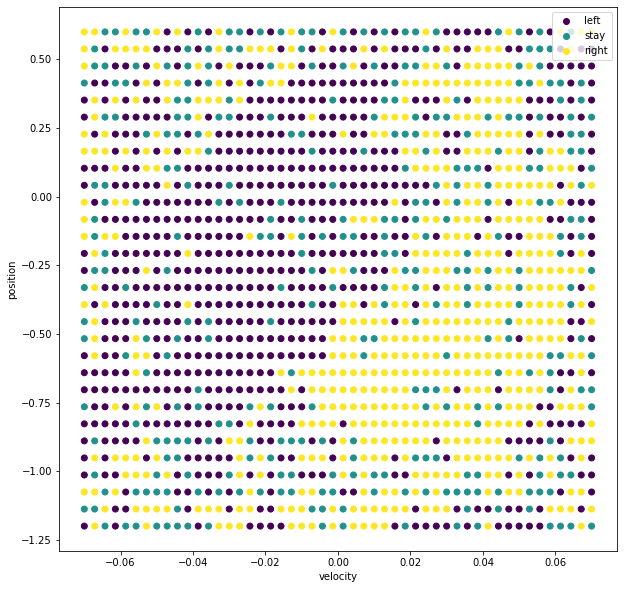

In [ ]:
# plotting the action space for the state space
states, actions = [], []
labels = ["left", "stay", "right"]

for position in range(q_table.shape[0]):
  for velocity in range(q_table.shape[1]):
    states.append((buckets[1][velocity], buckets[0][position]))
    actions.append(np.argmax(q_table[position, velocity]))

fig = plt.figure(figsize=(10, 10))
scatter = plt.scatter(*zip(*states), c=actions)

handles, _ = scatter.legend_elements()
plt.legend(handles, labels)

plt.xlabel("velocity")
plt.ylabel("position")
 
plt.show()
